<a href="https://colab.research.google.com/github/rocioamarelle/eccd_assignments_rocio/blob/main/Proyecto_Final_Grupo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Proyecto Final_Estrategias Comerciales con Datos**
#### Rocío Amarelle
#### Sofía Bianco
#### Andrés Bonino
#### Catalina Nicolini


### *Motivación y Objetivo del Proyecto*

*   Un Supermercado quiere mejorar la experiencia de sus clientes.
*   Actualmente los clientes pesan su propia fruta y verdura.
*   Clientes se han quejado de que cuesta encontrar el item correcto en la lista.
*   Objetivo: instalar una cámara que reconozca automáticamente el producto.

En este Proyecto vamos a utilizar el Tutorial de *Transfer Learning for Computer Vision* para entrenar un modelo que prediga la categoría de una fruta o verdura a partir de fotos. El modelo va a usarse para asignar automaticamente el precio al item, sin chequeo por parte del usuario.

## Transfer Learning for Computer Vision

In [ ]:
%matplotlib inline

In [ ]:
!pip install -q eccd_datasets

In [ ]:
## Carga de bibliotecas

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import io
from PIL import Image
from tempfile import TemporaryDirectory
from eccd_datasets import load_images

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data



In [ ]:
# Cargamos el dataset
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [ ]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 0 to 3481
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   dataset          2054 non-null   object
 1   coarse_cat       2054 non-null   object
 2   finegrained_cat  2054 non-null   object
 3   image_data       2054 non-null   object
dtypes: object(4)
memory usage: 80.2+ KB


In [ ]:
# Conteo de filas de train, test y validation
conteos_ttv = df_images['dataset'].value_counts()

print(conteos_ttv)

test     1322
train     675
val        57
Name: dataset, dtype: int64


In [ ]:
# Conteo por categoría de fruta en el dataset
conteos_frutas = df_images['coarse_cat'].value_counts()

print(conteos_frutas)

Apple       852
Melon       480
Pear        337
Satsumas    211
Orange      174
Name: coarse_cat, dtype: int64


El dataset contiene unicamente 5 frutas.

In [ ]:
# Conteo por variedad de cada fruta en el dataset
conteos_variedades = df_images['finegrained_cat'].value_counts()

print(conteos_variedades)

Satsumas            211
Royal-Gala          198
Pink-Lady           182
Granny-Smith        181
Orange              174
Red-Delicious       150
Watermelon          143
Golden-Delicious    141
Conference          138
Cantaloupe          123
Honeydew-Melon      112
Anjou               111
Galia-Melon         102
Kaiser               88
Name: finegrained_cat, dtype: int64


In [ ]:
# Conteo por fruta y por variedad de cada fruta
conteos_fru_var = df_images.groupby(['coarse_cat', 'finegrained_cat']).size()

print(conteos_fru_var)

coarse_cat  finegrained_cat 
Apple       Golden-Delicious    141
            Granny-Smith        181
            Pink-Lady           182
            Red-Delicious       150
            Royal-Gala          198
Melon       Cantaloupe          123
            Galia-Melon         102
            Honeydew-Melon      112
            Watermelon          143
Orange      Orange              174
Pear        Anjou               111
            Conference          138
            Kaiser               88
Satsumas    Satsumas            211
dtype: int64


In [ ]:
# Conteo por tipo de dataset y por variedad
conteos_ttv_fruta = df_images.groupby(['dataset', 'coarse_cat']).size()

print(conteos_ttv_fruta)

dataset  coarse_cat
test     Apple         552
         Melon         306
         Orange        112
         Pear          216
         Satsumas      136
train    Apple         278
         Melon         154
         Orange         57
         Pear          116
         Satsumas       70
val      Apple          22
         Melon          20
         Orange          5
         Pear            5
         Satsumas        5
dtype: int64


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = sorted(dataframe['coarse_cat'].unique())

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_data = self.dataframe.iloc[idx, 3]  # 'image_data' está en la cuarta columna de df_images
        label = self.dataframe.iloc[idx, 1]  # El nombre de la fruta está en la segunda columna ('coarse_cat')

        # Convertimos imagen cruda (raw image) en un objeto PIL Image
        image = Image.open(io.BytesIO(img_data))

        if self.transform:
            image = self.transform(image)

        # Convertimos la etiqueta de string a una etiqueta int
        label = self.classes.index(label)

        return image, label

# Convertimos el dataframe con formato Pandas a uno con formato PyTorch
image_datasets = {x: CustomImageDataset(df_images[df_images['dataset'] == x], transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



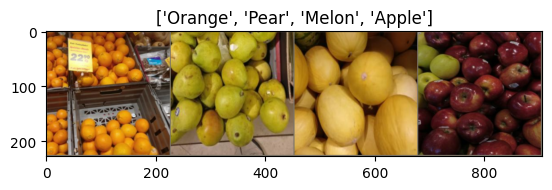

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9364 Acc: 0.6519
val Loss: 0.4775 Acc: 0.8246

Epoch 1/24
----------
train Loss: 0.6375 Acc: 0.7674
val Loss: 0.4685 Acc: 0.8246

Epoch 2/24
----------
train Loss: 0.5321 Acc: 0.8074
val Loss: 0.3039 Acc: 0.9123

Epoch 3/24
----------
train Loss: 0.3982 Acc: 0.8800
val Loss: 0.3568 Acc: 0.8772

Epoch 4/24
----------
train Loss: 0.5176 Acc: 0.8267
val Loss: 0.4737 Acc: 0.7544

Epoch 5/24
----------
train Loss: 0.5565 Acc: 0.8163
val Loss: 0.1710 Acc: 0.9298

Epoch 6/24
----------
train Loss: 0.3318 Acc: 0.8830
val Loss: 0.2374 Acc: 0.9123

Epoch 7/24
----------
train Loss: 0.2622 Acc: 0.9111
val Loss: 0.2011 Acc: 0.9474

Epoch 8/24
----------
train Loss: 0.2938 Acc: 0.9022
val Loss: 0.1955 Acc: 0.9123

Epoch 9/24
----------
train Loss: 0.1902 Acc: 0.9363
val Loss: 0.1704 Acc: 0.9474

Epoch 10/24
----------
train Loss: 0.1956 Acc: 0.9333
val Loss: 0.2897 Acc: 0.8772

Epoch 11/24
----------
train Loss: 0.2176 Acc: 0.9319
val Loss: 0.2014 Acc: 0.9474

Ep

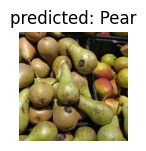

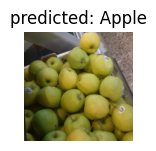

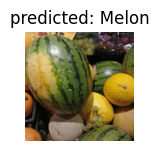

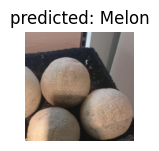

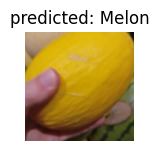

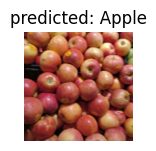

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0446 Acc: 0.6222
val Loss: 0.4919 Acc: 0.8421

Epoch 1/24
----------
train Loss: 0.7618 Acc: 0.7170
val Loss: 0.4741 Acc: 0.8421

Epoch 2/24
----------
train Loss: 0.6907 Acc: 0.7304
val Loss: 0.4102 Acc: 0.8421

Epoch 3/24
----------
train Loss: 0.7050 Acc: 0.7393
val Loss: 0.5071 Acc: 0.7719

Epoch 4/24
----------
train Loss: 0.5916 Acc: 0.7926
val Loss: 0.4904 Acc: 0.7895

Epoch 5/24
----------
train Loss: 0.6238 Acc: 0.7822
val Loss: 0.4868 Acc: 0.8070

Epoch 6/24
----------
train Loss: 0.6413 Acc: 0.7793
val Loss: 0.5100 Acc: 0.8070

Epoch 7/24
----------
train Loss: 0.4275 Acc: 0.8563
val Loss: 0.5133 Acc: 0.8421

Epoch 8/24
----------
train Loss: 0.5085 Acc: 0.8163
val Loss: 0.4652 Acc: 0.8070

Epoch 9/24
----------
train Loss: 0.4587 Acc: 0.8193
val Loss: 0.5053 Acc: 0.7544

Epoch 10/24
----------
train Loss: 0.4550 Acc: 0.8341
val Loss: 0.4379 Acc: 0.8246

Epoch 11/24
----------
train Loss: 0.4609 Acc: 0.8415
val Loss: 0.4477 Acc: 0.8421

Ep

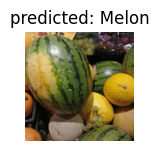

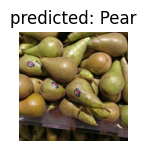

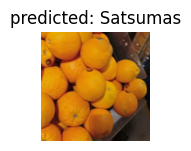

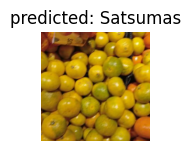

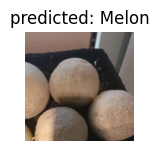

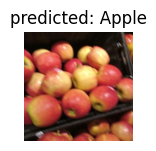

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [ ]:
# Definimos transformaciones
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Creamos un CustomImageDataset
dataset = CustomImageDataset(df_images, transform=transform)

In [ ]:
def visualize_model_predictions(model, dataset, idx):
    was_training = model.training
    model.eval()

    # Obtener la imagen y la etiqueta del dataset
    image, label = dataset[idx]
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {dataset.classes[preds[0]]}')
        imshow(image.cpu().data[0])

    model.train(mode=was_training)

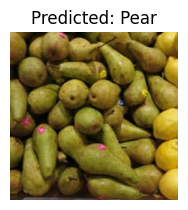

In [ ]:
# Seleccionamos un índice correspondiente a una imagen de nuestro dataset
idx = 300

# Utilizamos la función de visualización
visualize_model_predictions(model_conv, dataset, idx)

##Evaluación de los modelos

In [ ]:
# Precios de las frutas por kilo
precios = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
}

def calcular_costo(x, y):
    if x >= y:
        return 5 * (x - y)
    else:
        return y - x

# Asociar los nombres de las clases con los precios
precios_por_clase = [precios[clase] for clase in class_names]

### Matrices de Confusión

*Modelo "model_ft"- Finetuning the ConvNet sobre los datos de validación*

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Función para evaluar modelo con datos de validación a través de una matriz de confusión multiclase
def evaluate_model_val(model, dataloader, class_names, title=None):

    dataloader = dataloaders['val']

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Obtener probabilidades
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Guardar probabilidades
            all_labels.extend(labels.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    if title is not None:
         plt.title(title)
    plt.show()

    # Calcular precisión, recall y f1-score
    precision = precision_score(all_labels, all_preds, average=None) * 100  # Convertir a porcentaje
    recall = recall_score(all_labels, all_preds, average=None) * 100  # Convertir a porcentaje
    f1 = f1_score(all_labels, all_preds, average=None) * 100  # Convertir a porcentaje

    # Printear precisión y recall para cada clase en porcentaje
    for i, class_name in enumerate(class_names):
        print(f"Clase {class_name}:")
        print(f"   Precisión: {precision[i]:.2f}%")
        print(f"   Recall: {recall[i]:.2f}%")
        print(f"   F1-Score: {f1[i]:.2f}%")

    y_scores = np.array(all_probs)  # Convertir all_probs a un array de NumPy
    y_true = np.array(all_labels)  # Convertir all_labels a un array de NumPy


    return cm, precision, recall, f1, all_probs, all_labels, y_scores, y_true

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


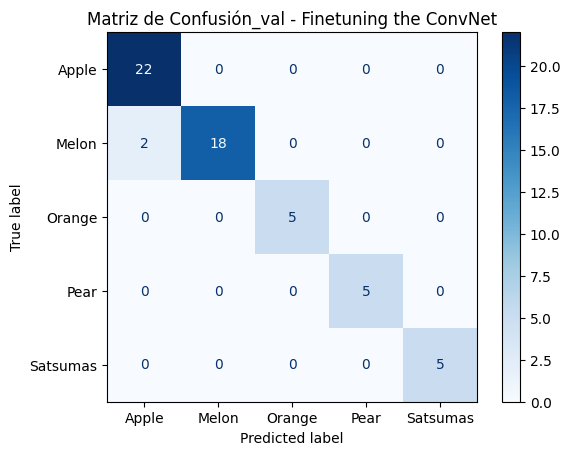

Clase Apple:
   Precisión: 91.67%
   Recall: 100.00%
   F1-Score: 95.65%
Clase Melon:
   Precisión: 100.00%
   Recall: 90.00%
   F1-Score: 94.74%
Clase Orange:
   Precisión: 100.00%
   Recall: 100.00%
   F1-Score: 100.00%
Clase Pear:
   Precisión: 100.00%
   Recall: 100.00%
   F1-Score: 100.00%
Clase Satsumas:
   Precisión: 100.00%
   Recall: 100.00%
   F1-Score: 100.00%


In [ ]:
cm_ft_val, precision_ft_val, recall_ft_val, f1_ft_val, all_probs_ft_val, all_labels_ft_val, y_scores_ft_val, y_true_ft_val = evaluate_model_val(model_ft, dataloaders, class_names, 'Matriz de Confusión_val - Finetuning the ConvNet')

In [ ]:
# Función para calcular costo total de los errores de clasificación
def calcular_costo_total(class_names, cm, prices_per_class):
    costo_total = 0
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:  # Solo para celdas fuera de la diagonal
                costo_error = calcular_costo(precios_por_clase[j], precios_por_clase[i])
                costo_total += costo_error * cm[i,j]
    return costo_total

In [ ]:
costo_total_ft_val = calcular_costo_total(class_names, cm_ft_val, precios_por_clase)
print(f"Costo total debido a errores de clasificación: ${costo_total_ft_val}")

Costo total debido a errores de clasificación: $70


*Modelo "model_conv"- ConvNet as fixed feature extractor sobre los datos de validación*

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


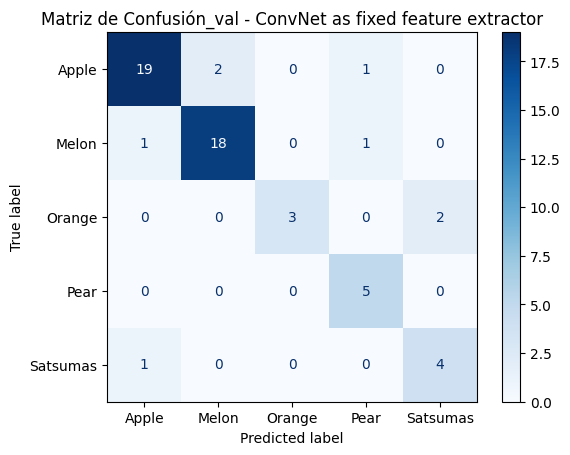

Clase Apple:
   Precisión: 90.48%
   Recall: 86.36%
   F1-Score: 88.37%
Clase Melon:
   Precisión: 90.00%
   Recall: 90.00%
   F1-Score: 90.00%
Clase Orange:
   Precisión: 100.00%
   Recall: 60.00%
   F1-Score: 75.00%
Clase Pear:
   Precisión: 71.43%
   Recall: 100.00%
   F1-Score: 83.33%
Clase Satsumas:
   Precisión: 66.67%
   Recall: 80.00%
   F1-Score: 72.73%


In [ ]:
cm_conv_val, precision_conv_val, recall_conv_val, f1_conv_val, all_probs_conv_val, all_labels_conv_val, y_scores_conv_val, y_true_conv_val = evaluate_model_val(model_conv, dataloaders, class_names, 'Matriz de Confusión_val - ConvNet as fixed feature extractor')

In [ ]:
costo_total_conv_val = calcular_costo_total(class_names, cm_conv_val, precios_por_clase)
print(f"Costo total debido a errores de clasificación: ${costo_total_conv_val}")

Costo total debido a errores de clasificación: $720


*Modelo "model_ft"- Finetuning the ConvNet sobre los datos de prueba (test)*

In [ ]:
# Transformaciones para los datos de test
data_transforms['test'] = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Convertimos el dataframe con formato Pandas a uno con formato PyTorch
image_datasets = {x: CustomImageDataset(df_images[df_images['dataset'] == x], transform=data_transforms[x])
                  for x in ['test']}

dataloaders_ = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Función para evaluar modelo con datos de test a través de una matriz de confusión multiclase
def evaluate_model_test(model, dataloader, class_names, title=None):

    dataloader = dataloaders_['test']

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Obtener probabilidades
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Guardar probabilidades
            all_labels.extend(labels.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    if title is not None:
         plt.title(title)
    plt.show()

    # Calcular precisión y recall
    precision = precision_score(all_labels, all_preds, average=None) * 100  # Convertir a porcentaje
    recall = recall_score(all_labels, all_preds, average=None) * 100  # Convertir a porcentaje
    f1 = f1_score(all_labels, all_preds, average=None) * 100  # Convertir a porcentaje

    # Printear precisión y recall para cada clase en porcentaje
    for i, class_name in enumerate(class_names):
        print(f"Clase {class_name}:")
        print(f"   Precisión: {precision[i]:.2f}%")
        print(f"   Recall: {recall[i]:.2f}%")
        print(f"   F1-Score: {f1[i]:.2f}%")

    y_scores = np.array(all_probs)  # Convertir all_probs a un array de NumPy
    y_true = np.array(all_labels)  # Convertir all_labels a un array de NumPy

    return cm, precision, recall, f1, all_probs, all_labels, y_scores, y_true

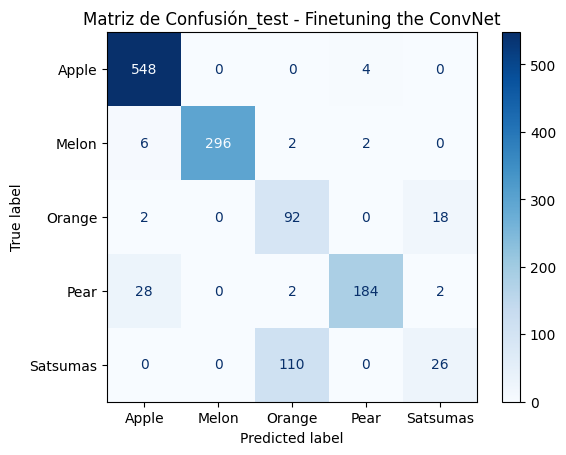

Clase Apple:
   Precisión: 93.84%
   Recall: 99.28%
   F1-Score: 96.48%
Clase Melon:
   Precisión: 100.00%
   Recall: 96.73%
   F1-Score: 98.34%
Clase Orange:
   Precisión: 44.66%
   Recall: 82.14%
   F1-Score: 57.86%
Clase Pear:
   Precisión: 96.84%
   Recall: 85.19%
   F1-Score: 90.64%
Clase Satsumas:
   Precisión: 56.52%
   Recall: 19.12%
   F1-Score: 28.57%


In [ ]:
cm_ft_test, precision_ft_test, recall_ft_test, f1_ft_test, all_probs_ft_test, all_labels_ft_test, y_scores_ft_test, y_true_ft_test  = evaluate_model_test(model_ft, dataloaders_, class_names, 'Matriz de Confusión_test - Finetuning the ConvNet')

Predice mal algunas clases ('Satsumas' y 'Orange').

In [ ]:
costo_total_ft_test = calcular_costo_total(class_names, cm_ft_test, precios_por_clase)
print(f"Costo total debido a errores de clasificación: ${costo_total_ft_test}")

Costo total debido a errores de clasificación: $3506


*Modelo "model_conv"- ConvNet as fixed feature extractor sobre los datos de prueba (test)*

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


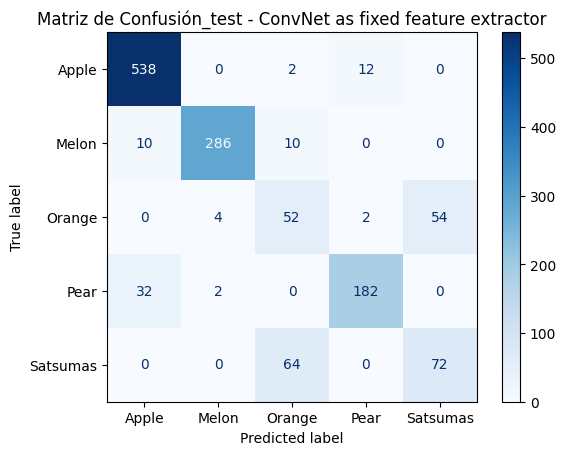

Clase Apple:
   Precisión: 92.76%
   Recall: 97.46%
   F1-Score: 95.05%
Clase Melon:
   Precisión: 97.95%
   Recall: 93.46%
   F1-Score: 95.65%
Clase Orange:
   Precisión: 40.62%
   Recall: 46.43%
   F1-Score: 43.33%
Clase Pear:
   Precisión: 92.86%
   Recall: 84.26%
   F1-Score: 88.35%
Clase Satsumas:
   Precisión: 57.14%
   Recall: 52.94%
   F1-Score: 54.96%


In [ ]:
cm_conv_test, precision_conv_test, recall_conv_test, f1_conv_test, all_probs_conv_test, all_labels_conv_test, y_scores_conv_test, y_true_conv_test  = evaluate_model_test(model_conv, dataloaders_, class_names, 'Matriz de Confusión_test - ConvNet as fixed feature extractor')

También predice mal las mismas clases ('Satsumas' y 'Orange').

In [ ]:
costo_total_conv_test = calcular_costo_total(class_names, cm_conv_test, precios_por_clase)
print(f"Costo total debido a errores de clasificación: ${costo_total_conv_test}")

Costo total debido a errores de clasificación: $7774


**El costo total es menor en el modelo ft**

In [ ]:
# Creamos una tabla resumen

import pandas as pd

costos = {'model_ft_val': costo_total_ft_val, 'model_ft_test': costo_total_ft_test, 'model_conv_val': costo_total_conv_val, 'model_conv_test': costo_total_conv_test}

# Crear una lista con los nombres de los modelos, tipos de dataset y monto de los costos totales
data = []
for key, cost in costos.items():
    model_name, data_name = key.rsplit('_', 1)  # Separar en el último guión bajo
    data.append([model_name, data_name, cost])

# Crear un DataFrame
cost_df = pd.DataFrame(data, columns=['Modelo', 'Dataset', 'Costo Total'])

# Printear el df
print(cost_df)

       Modelo Dataset  Costo Total
0    model_ft     val           70
1    model_ft    test         3506
2  model_conv     val          720
3  model_conv    test         7774


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


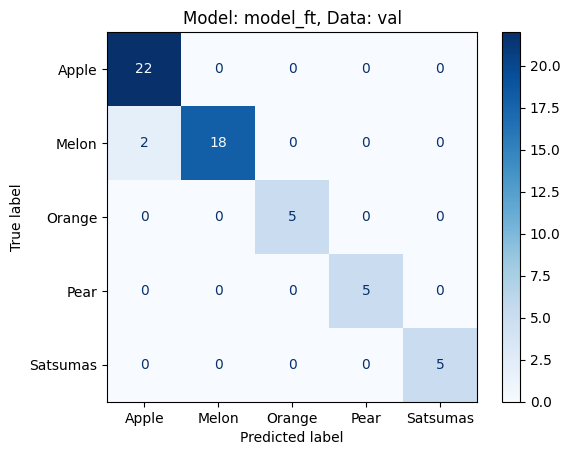

Clase Apple:
   Precisión: 91.67%
   Recall: 100.00%
   F1-Score: 95.65%
Clase Melon:
   Precisión: 100.00%
   Recall: 90.00%
   F1-Score: 94.74%
Clase Orange:
   Precisión: 100.00%
   Recall: 100.00%
   F1-Score: 100.00%
Clase Pear:
   Precisión: 100.00%
   Recall: 100.00%
   F1-Score: 100.00%
Clase Satsumas:
   Precisión: 100.00%
   Recall: 100.00%
   F1-Score: 100.00%


<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Re

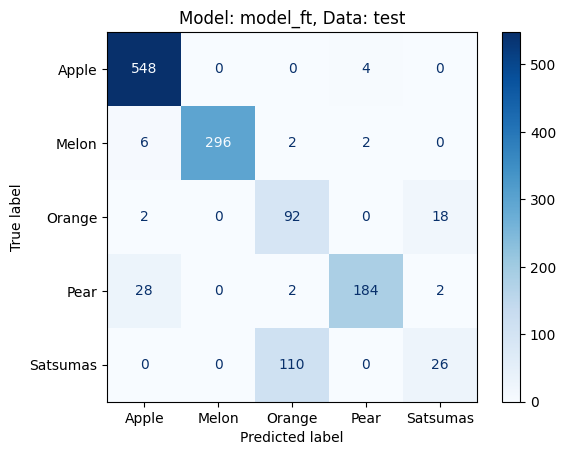

Clase Apple:
   Precisión: 93.84%
   Recall: 99.28%
   F1-Score: 96.48%
Clase Melon:
   Precisión: 100.00%
   Recall: 96.73%
   F1-Score: 98.34%
Clase Orange:
   Precisión: 44.66%
   Recall: 82.14%
   F1-Score: 57.86%
Clase Pear:
   Precisión: 96.84%
   Recall: 85.19%
   F1-Score: 90.64%
Clase Satsumas:
   Precisión: 56.52%
   Recall: 19.12%
   F1-Score: 28.57%


<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Re

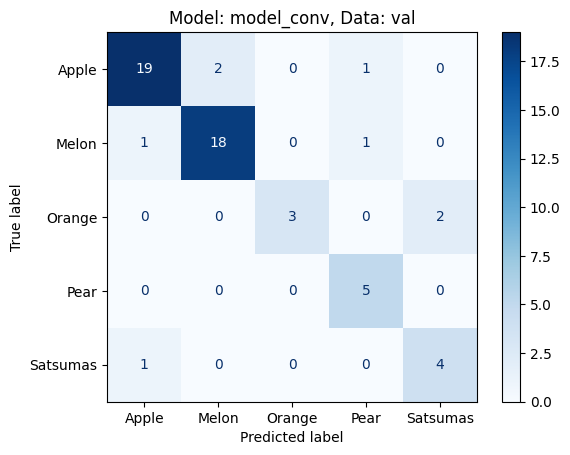

Clase Apple:
   Precisión: 90.48%
   Recall: 86.36%
   F1-Score: 88.37%
Clase Melon:
   Precisión: 90.00%
   Recall: 90.00%
   F1-Score: 90.00%
Clase Orange:
   Precisión: 100.00%
   Recall: 60.00%
   F1-Score: 75.00%
Clase Pear:
   Precisión: 71.43%
   Recall: 100.00%
   F1-Score: 83.33%
Clase Satsumas:
   Precisión: 66.67%
   Recall: 80.00%
   F1-Score: 72.73%


<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Re

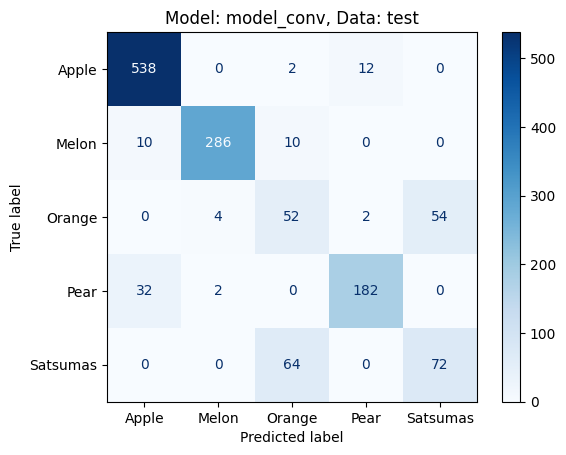

Clase Apple:
   Precisión: 92.76%
   Recall: 97.46%
   F1-Score: 95.05%
Clase Melon:
   Precisión: 97.95%
   Recall: 93.46%
   F1-Score: 95.65%
Clase Orange:
   Precisión: 40.62%
   Recall: 46.43%
   F1-Score: 43.33%
Clase Pear:
   Precisión: 92.86%
   Recall: 84.26%
   F1-Score: 88.35%
Clase Satsumas:
   Precisión: 57.14%
   Recall: 52.94%
   F1-Score: 54.96%
         Model  Data     Class   Precision      Recall    F1-Score
0     model_ft   val     Apple   91.666667  100.000000   95.652174
1     model_ft   val     Melon  100.000000   90.000000   94.736842
2     model_ft   val    Orange  100.000000  100.000000  100.000000
3     model_ft   val      Pear  100.000000  100.000000  100.000000
4     model_ft   val  Satsumas  100.000000  100.000000  100.000000
5     model_ft  test     Apple   93.835616   99.275362   96.478873
6     model_ft  test     Melon  100.000000   96.732026   98.338870
7     model_ft  test    Orange   44.660194   82.142857   57.861635
8     model_ft  test      Pear   9

<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)
<ipython-input-38-50946c7a59fc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Re

In [ ]:
# Crear un DataFrame vacío
metricas_df = pd.DataFrame(columns=['Model', 'Data', 'Class', 'Precision', 'Recall', 'F1-Score'])

# Calcular precisión, recall y f-1_score pra cada modelo y clase
models = {'model_ft': model_ft, 'model_conv': model_conv}
for model_name, model in models.items():
    for data_name, evaluate_model, dataloader in [('val', evaluate_model_val, dataloaders), ('test', evaluate_model_test, dataloaders_)]:
        title = f'Model: {model_name}, Data: {data_name}'
        cm, precision, recall, f1, all_probs, all_labels, y_scores, y_true = evaluate_model(model, dataloader[data_name], class_names, title=title)
        for i, class_name in enumerate(class_names):
            metricas_df = metricas_df.append({'Model': model_name, 'Data': data_name, 'Class': class_name, 'Precision': precision[i], 'Recall': recall[i],'F1-Score': f1[i]}, ignore_index=True)

# Printear el df
print(metricas_df)

*Curvas ROC del Modelo "model_ft"- Finetuning the ConvNet sobre los datos de validación*

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

# Función para graficar curvas ROC

def plot_roc_curves(y_scores, y_true, class_names, title):
    # Binarizar la salida
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    n_classes = y_true_bin.shape[1]

    # Calcular la curva ROC y el área bajo la curva ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la curva ROC de promedio micro y el área bajo la curva ROC de promedio micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plotear todas las curvas ROC
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-promedio de la curva ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Curva ROC de clase {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

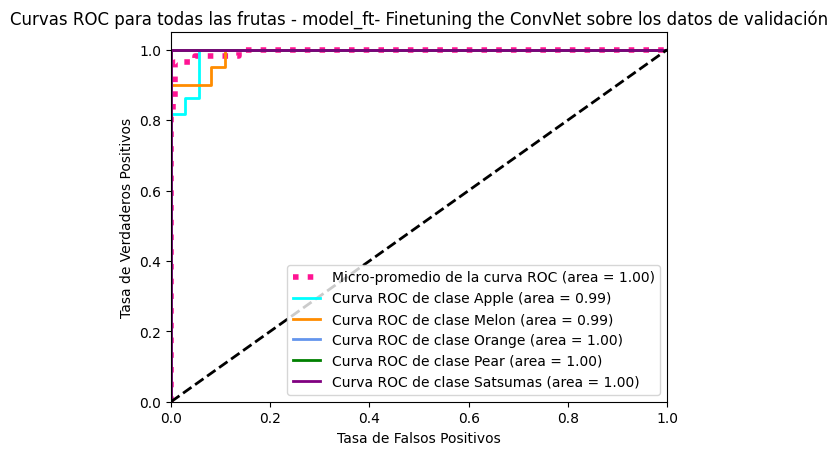

In [ ]:
plot_roc_curves(y_scores_ft_val, y_true_ft_val, class_names, 'Curvas ROC para todas las frutas - model_ft- Finetuning the ConvNet sobre los datos de validación')

*Curvas ROC del Modelo "model_conv"- ConvNet as fixed feature extractor sobre los datos de validación*

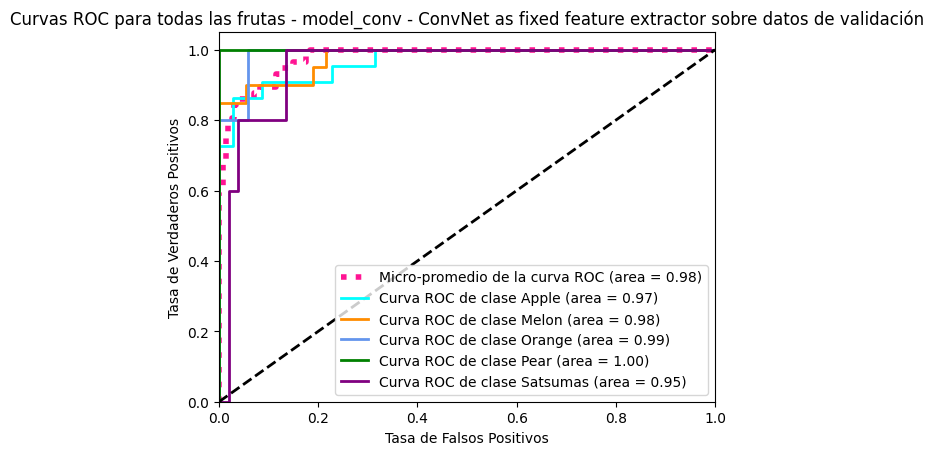

In [ ]:
plot_roc_curves(y_scores_conv_val, y_true_conv_val, class_names, 'Curvas ROC para todas las frutas - model_conv - ConvNet as fixed feature extractor sobre datos de validación')

*Curvas ROC para todas las frutas - model_ft - Finetuning the ConvNet sobre datos de prueba(test)*

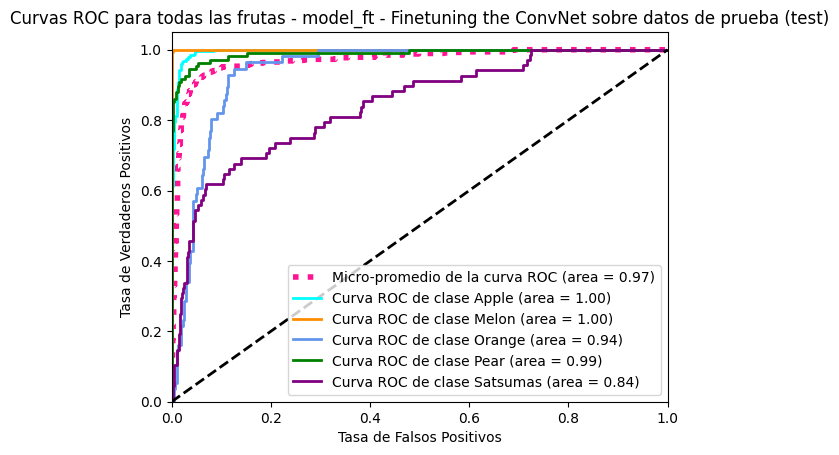

In [ ]:
plot_roc_curves(y_scores_ft_test, y_true_ft_test, class_names, 'Curvas ROC para todas las frutas - model_ft - Finetuning the ConvNet sobre datos de prueba (test)')

*Curvas ROC para todas las frutas - model_conv - ConvNet as fixed feature extractor sobre datos de prueba (test)*

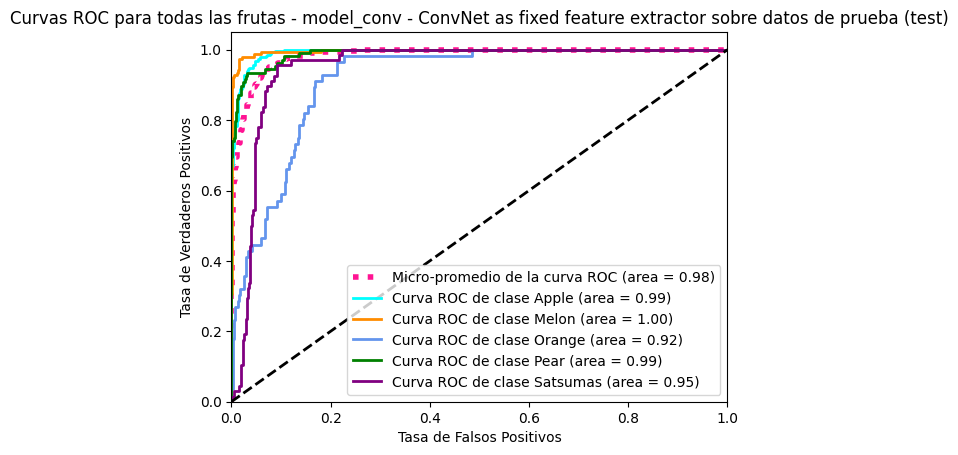

In [ ]:
plot_roc_curves(y_scores_conv_test, y_true_conv_test, class_names, 'Curvas ROC para todas las frutas - model_conv - ConvNet as fixed feature extractor sobre datos de prueba (test)')

AUC del Modelo "model_ft" - Finetuning the ConvNet sobre los datos de validación



In [ ]:
from sklearn.metrics import roc_auc_score

def plot_auc(y_scores, y_true, class_names):
    # Binarizar la salida
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    n_classes = y_true_bin.shape[1]

    # Calcular la curva ROC y el área bajo la curva ROC para cada clase
    roc_auc = dict()
    for i in range(n_classes):
        roc_auc[class_names[i]] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])

    # Calcular la curva ROC de Micro-promedio y el área bajo la curva ROC de Micro-promedio
    roc_auc["Micro-promedio"] = roc_auc_score(y_true_bin.ravel(), y_scores.ravel())

    # Ordenar las clases por AUC
    sorted_classes = sorted(roc_auc.items(), key=lambda item: item[1])

     # Define colors
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'magenta']

    # Plotear los scores de AUC
    plt.figure()
    bar_height = 0.35
    y_positions = range(len(sorted_classes))

    for i, (class_name, auc) in enumerate(sorted_classes):
        plt.barh(i, auc, color=colors[i], height=bar_height,
                 label='AUC de clase {0} = {1:0.2f}'
                 ''.format(class_name, auc))

    plt.yticks(y_positions, [class_name for class_name, _ in sorted_classes])
    plt.xlabel('AUC')
    plt.ylabel('Clase')
    plt.title('AUC para cada clase')
    plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0))
    plt.show()

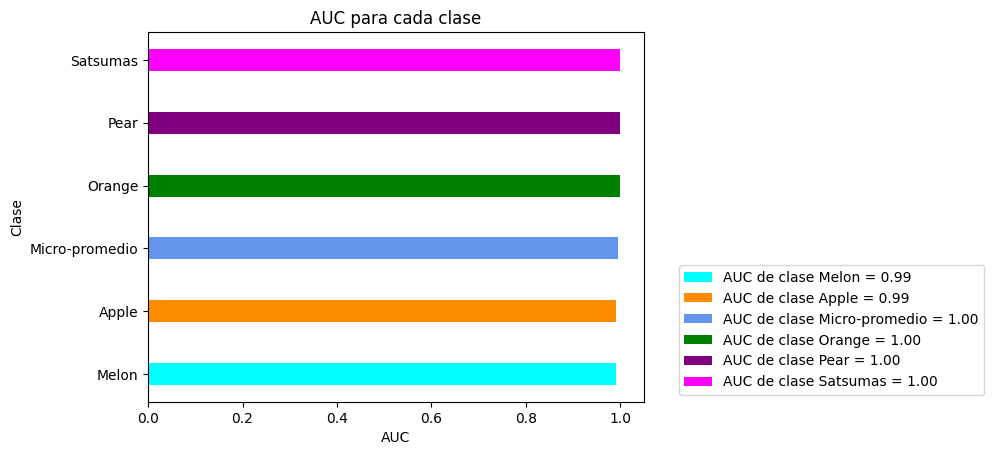

In [ ]:
plot_auc(y_scores_ft_val, y_true_ft_val, class_names)

AUC del Modelo "model_conv"- ConvNet as fixed feature extractor sobre los datos de validación



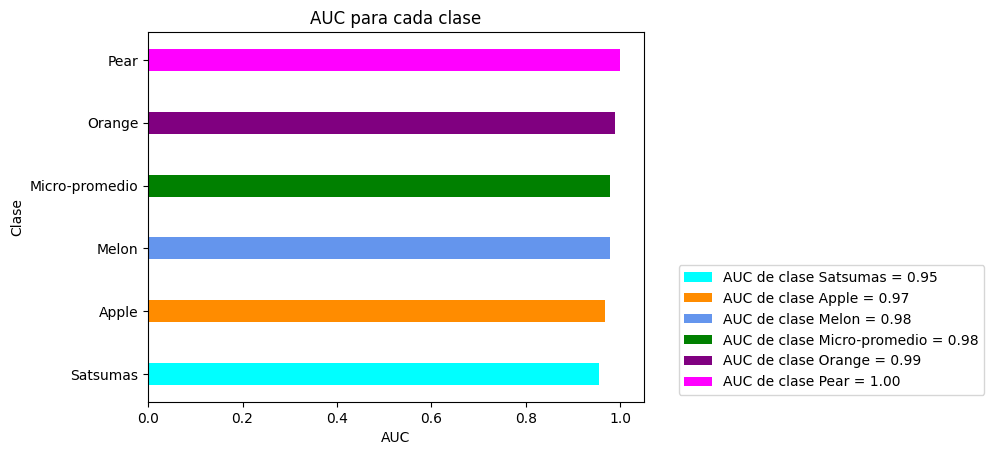

In [ ]:
plot_auc(y_scores_conv_val, y_true_conv_val, class_names)

AUC del Modelo "model_ft" - Finetuning the ConvNet sobre los datos de prueba (test)


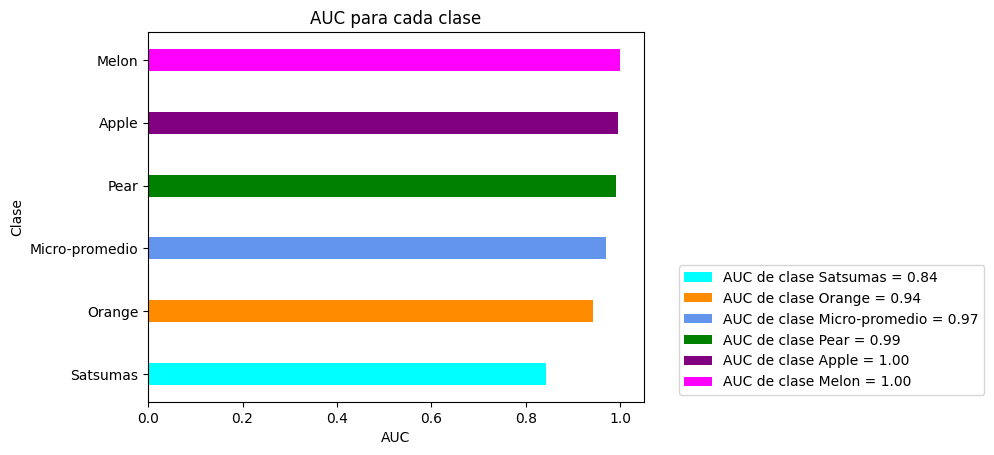

In [ ]:
plot_auc(y_scores_ft_test, y_true_ft_test, class_names)

AUC del Modelo "model_conv"- ConvNet as fixed feature extractor sobre los datos de prueba (test)

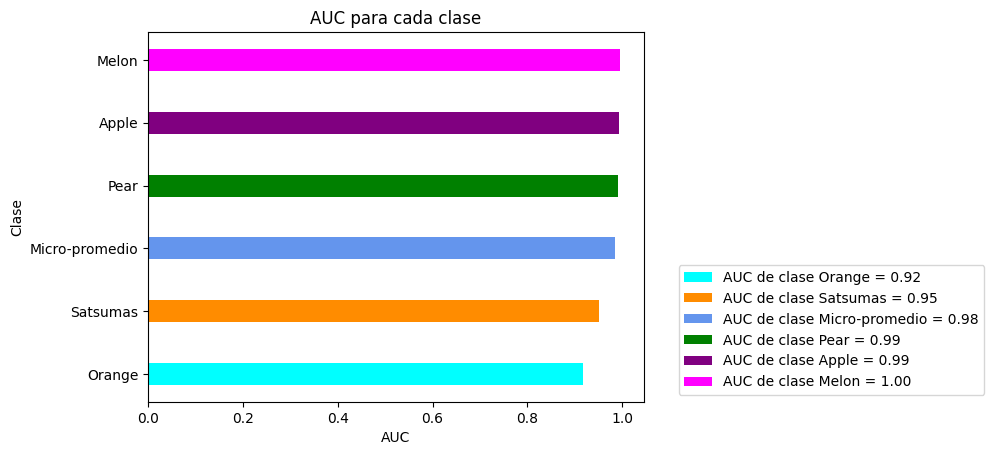

In [ ]:
plot_auc(y_scores_conv_test, y_true_conv_test, class_names)

**Comparación de costos respecto a ingresos potenciales de no existir errores de clasificación**

In [ ]:
# Asumimos que cada fila corresponde a un kilo, por lo que el total de datos de cada fruta se corresponde con el total de kilos de la misma
total_kilos_test = {"Apple": 552, "Melon": 306, "Orange": 112, "Pear": 216, "Satsumas": 136}

# Calculamos los ingresos por fruta si no existieran errores de clasificación
ingresos_test = {fruta: total_kilos_test[fruta] * precios[fruta] for fruta in total_kilos_test}

# Calculamos los ingresos totales si no existieran errores de clasificación
ingresos_totales = sum(ingresos_test.values())

print(ingresos_test)
print(ingresos_totales)


{'Apple': 40848, 'Melon': 33354, 'Orange': 3920, 'Pear': 19224, 'Satsumas': 5984}
103330
